# Задание 1
### CV
##### Булыгин Артем, Б05-811

# Color Filter Array Recovery Using a Threshold-based Variable Number of Gradients

## Импорты и картинка

In [1]:
import cv2 as cv
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

В этой картинке 8.7 мегапикселя


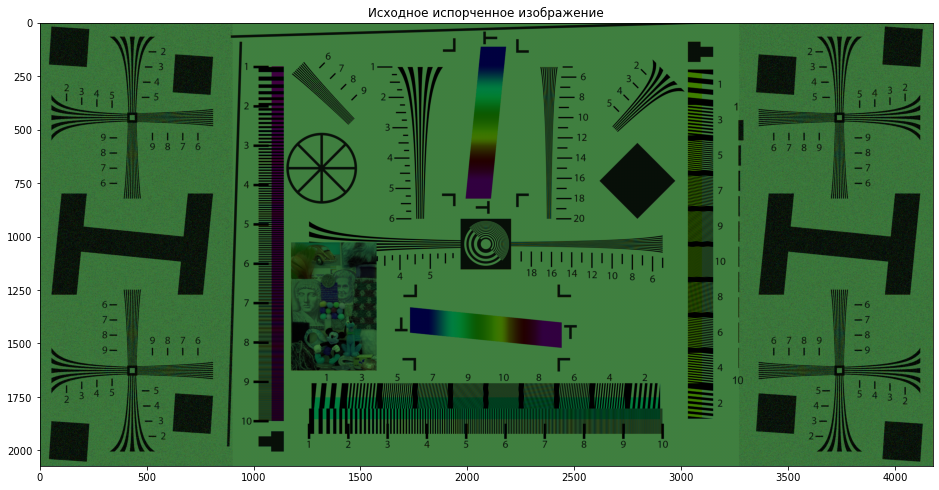

In [20]:
image = cv.imread('RGB_CFA.bmp',1)
megapixels = image.shape[0] * image.shape[1] / 1000 / 1000
print('В этой картинке {:.2} мегапикселя'.format(megapixels))
plt.figure(figsize = (16, 9))
plt.imshow(image)
plt.title('Исходное испорченное изображение')
plt.show()

## Алгоритм

In [3]:
def get_gradients(pixels, color):
    grads = np.zeros((3, 3))
    
    div1 = np.array([[0.5, 1, 0.5], 
                     [0.5, 1, 0.5]])
    div2 = np.array([[0, 0.5, 0],
                     [0.5, 0, 0.5], 
                     [0, 0.5, 0]])
    
    
    grads[0, 1] = np.sum(np.abs(pixels[:2] - pixels[2:4])[:, 1:4] * div1) # N
    grads[1, 0] = np.sum(np.abs(pixels[:, :2] - pixels[:, 2:4])[1:4] * div1.T) # W
    grads[1, 2] = np.sum(np.abs(pixels[:, 1:3] - pixels[:, 3:])[1:4] * div1.T) # E
    grads[2, 1] = np.sum(np.abs(pixels[1:3] - pixels[3:])[:, 1:4] * div1) # S

    if color == 1:
        grads[0, 0] = np.sum(np.abs(pixels[:2, :2] - pixels[2:4, 2:4])) # NW
        grads[0, 2] = np.sum(np.abs(pixels[:2, 3:] - pixels[2:4, 1:3])) # NE
        grads[2, 0] = np.sum(np.abs(pixels[3:, :2] - pixels[1:3, 2:4])) # SW
        grads[2, 2] = np.sum(np.abs(pixels[3:, 3:] - pixels[1:3, 1:3])) # SE
    else:
        grads[0, 0] = np.sum(np.abs(pixels[:3, :3] - pixels[1:4, 1:4]) * div2) + \
                      np.sum(np.diag(np.abs(pixels[:2, :2] - pixels[2:4, 2:4]))) # NW
        grads[0, 2] = np.sum(np.abs(pixels[:3, 2:] - pixels[1:4, 1:4]) * div2) + \
                      np.sum(np.diag(np.rot90(np.abs(pixels[:2, 3:] - pixels[2:4, 1:3])))) # NE
        grads[2, 0] = np.sum(np.abs(pixels[2:, :3] - pixels[1:4, 1:4]) * div2) + \
                      np.sum(np.diag(np.rot90(np.abs(pixels[3:, :2] - pixels[1:3, 2:4])))) # SW
        grads[2, 2] = np.sum(np.abs(pixels[2:, 2:] - pixels[1:4, 1:4]) * div2) + \
                      np.sum(np.diag(np.abs(pixels[3:, 3:] - pixels[1:3, 1:3]))) # SE
    return grads

In [96]:
def get_restored_pixel(pixels, color_map):
    color = color_map[2, 2]
    grads = get_gradients(pixels, color)
    
    k1 = 1.5
    k2 = 0.5
    try:
        MIN = np.min(grads[grads!=0])
        MAX = np.max(grads[grads!=0])
    except:
        MIN = 0
        MAX = 0
    t = k1 * MIN + k2 * (MIN + MAX)
    directions = grads <= t
    directions[1, 1] = False

    reds = pixels * (color_map == 0)
    greens = pixels * (color_map == 1)
    blues = pixels * (color_map == 2)
    
    total = np.zeros(3)

    for i in range(3):
        for j in range(3):
            if directions[i, j]:
                total[0] += np.mean(reds[i:i + 3, j:j+3][color_map[i:i + 3, j:j+3] == 0])
                total[1] += np.mean(greens[i:i + 3, j:j+3][color_map[i:i + 3, j:j+3] == 1])
                total[2] += np.mean(blues[i:i + 3, j:j+3][color_map[i:i + 3, j:j+3] == 2])
    restored_pixel = np.array([0, 0, 0])
    restored_pixel[color] = pixels[2, 2]
    if directions.sum() != 0:
        try:
            restored_pixel[(color + 1) % 3] = pixels[2, 2] + (total[(color + 1) % 3] - total[color])/ directions.sum()
            restored_pixel[(color + 2) % 3] = pixels[2, 2] + (total[(color + 2) % 3] - total[color])/ directions.sum()
        except Exception as e:
            print(total)
            print(color_map)
            raise e
    else:
        restored_pixel[(color + 1) % 3] = pixels[2, 2]
        restored_pixel[(color + 2) % 3] = pixels[2, 2]
    return restored_pixel

In [102]:
def VNG(image):
    width = image.shape[1]
    height = image.shape[0]
    
    restored_image = np.zeros_like(image)
    
    padded_flat_image = np.full((image.shape[0] + 4, image.shape[1] + 4), 255)
    padded_flat_image[2:-2, 2:-2] = image.max(axis=2)
    
    color_map = np.tile(np.array([[2, 1], [1, 0]]), (height // 2 + 3, width // 2 + 3))[:height + 4, :width + 4]
    
    for i in tqdm(range(2, height + 2)):
        for j in range(2, width + 2):
            restored_image[i - 2, j - 2] = get_restored_pixel(padded_flat_image[i - 2:i + 3, j - 2:j + 3], 
                                                     color_map[i - 2:i + 3, j - 2:j + 3])
            
    return restored_image

## Время на 1 мегапиксель


Потрачено 457.704928 секунд


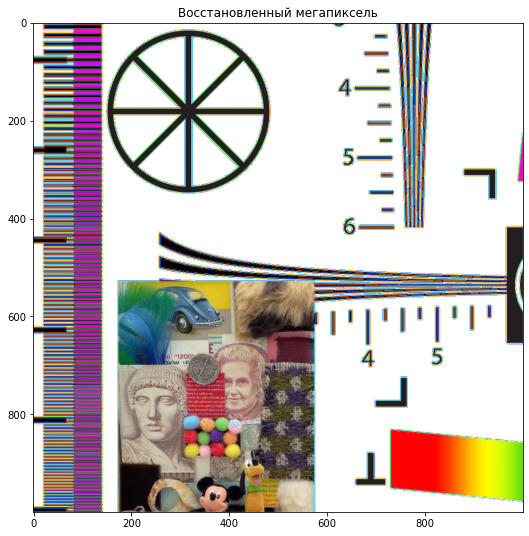

In [105]:
t1 = datetime.now()
restored_image = VNG(image[500:1500, 1000:2000])
t2 = datetime.now()
restored_image = cv.cvtColor(restored_image, cv.COLOR_BGR2RGB)
print('Потрачено {:} секунд'.format((t2 - t1).total_seconds()))
plt.figure(figsize = (16, 9))
plt.imshow(restored_image)
plt.title('Восстановленный мегапиксель')
plt.show()

## Восстанавливаем всё изображение


Потрачено 4323.736128 секунд


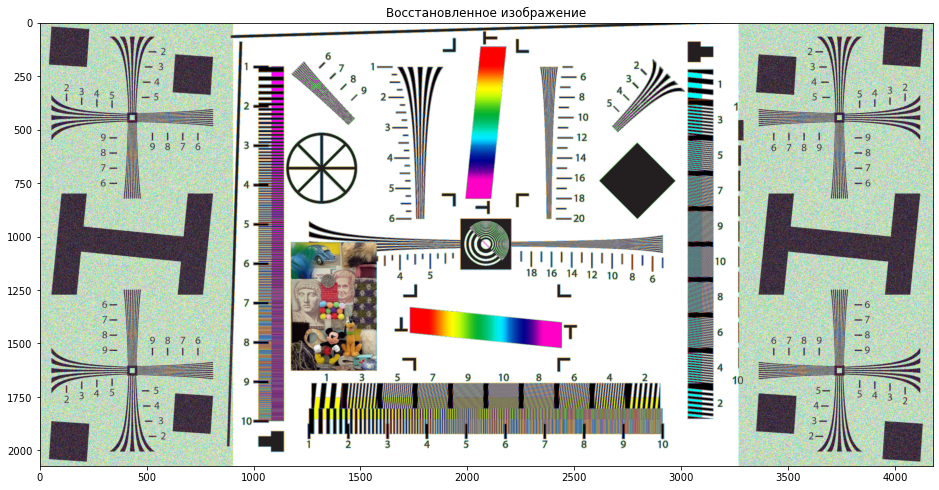

True

In [77]:
t1 = datetime.now()
full_restored_image = VNG(image)
t2 = datetime.now()
full_restored_image = cv.cvtColor(full_restored_image, cv.COLOR_BGR2RGB)
print('Потрачено {:} секунд'.format((t2 - t1).total_seconds()))
plt.figure(figsize = (16, 9))
plt.imshow(full_restored_image)
plt.title('Восстановленное изображение')
plt.show()

In [82]:
full_restored_image = cv.cvtColor(full_restored_image, cv.COLOR_RGB2BGR)
cv.imwrite('Restored.bmp', full_restored_image)

True

## PSNR

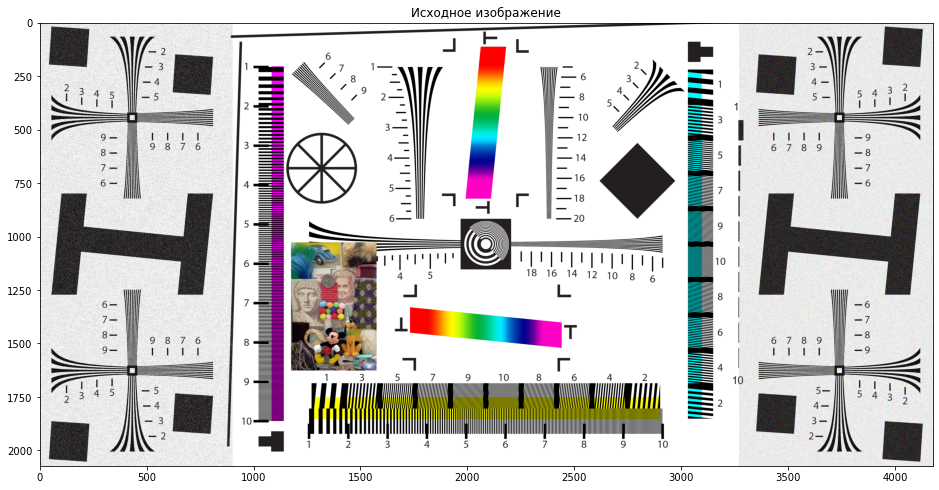

In [83]:
origin = cv.imread('Original.bmp')
origin = cv.cvtColor(origin, cv.COLOR_BGR2RGB)
plt.figure(figsize = (16, 9))
plt.imshow(origin)
plt.title('Исходное изображение')
plt.show()

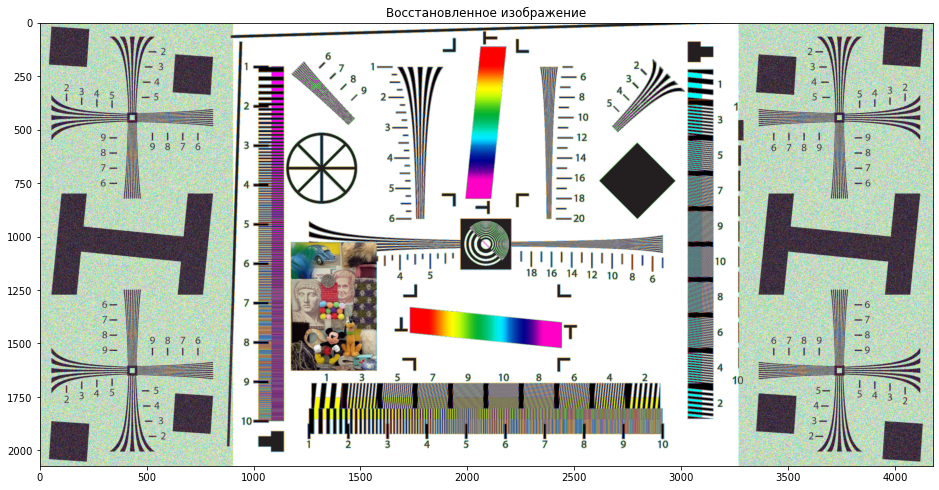

In [84]:
restored = cv.imread('restored.bmp')
restored = cv.cvtColor(restored, cv.COLOR_BGR2RGB)
plt.figure(figsize = (16, 9))
plt.imshow(restored)
plt.title('Восстановленное изображение')
plt.show()

In [85]:
Y_max = 255
Y = 0.299 * restored[:,:,0] + 0.587 * restored[:,:,1] + 0.114 * restored[:,:,2]
Y_ref = 0.299 * origin[:,:,0] + 0.587 * origin[:,:,1] + 0.114 * origin[:,:,2]
MSE = ((Y - Y_ref)**2).mean()
PSNR = 10 * np.log10(Y_max ** 2 / MSE)
print("Значение метрики PSNR равно", PSNR)

Значение метрики PSNR равно 15.33339702684388


## Разрешение

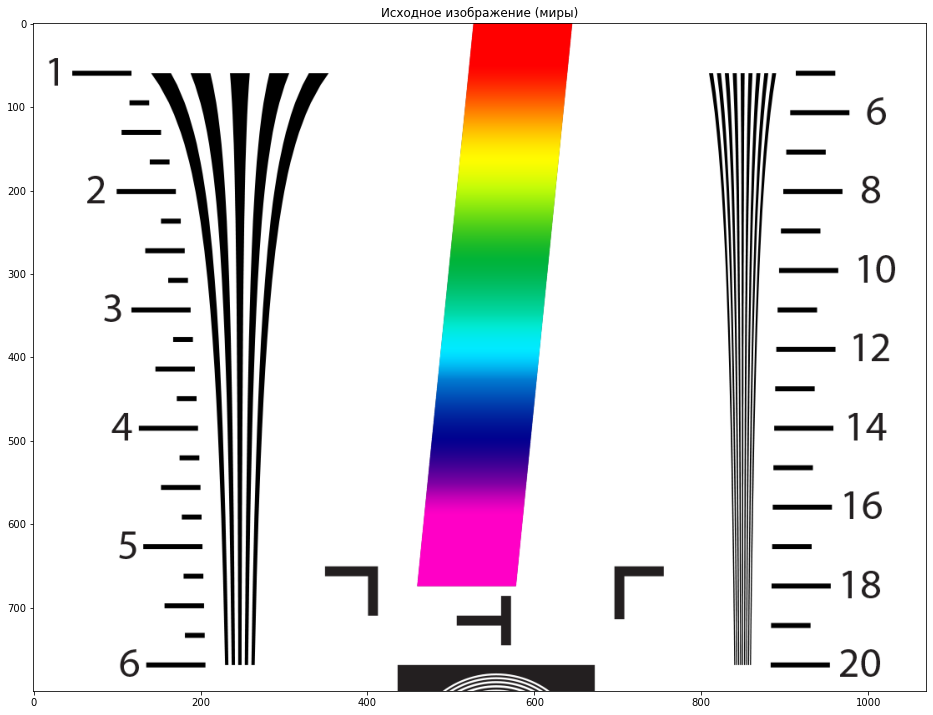

In [86]:
plt.figure(figsize = (16, 16))
plt.imshow(origin[150:950, 1530:2600])
plt.title('Исходное изображение (миры)')
plt.show()

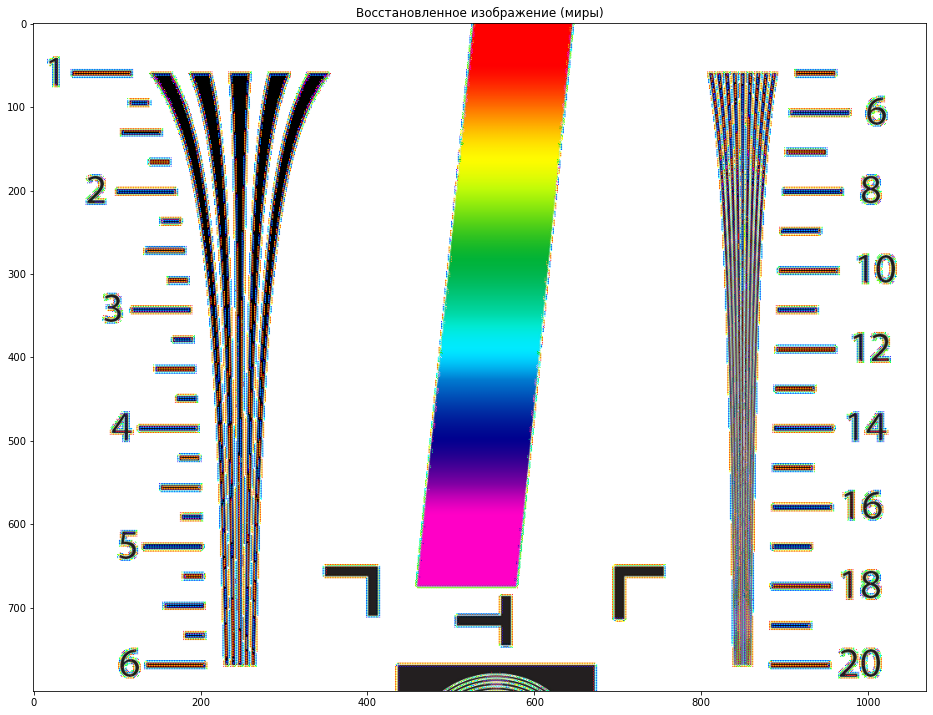

In [87]:
plt.figure(figsize = (16, 16))
plt.imshow(restored[150:950, 1530:2600])
plt.title('Восстановленное изображение (миры)')
plt.show()

Визуальный анализ мир восстановленного изображения позволяет сделать вывод, что разрешение снизилось в $\frac{20}{12} = 1.667$ раза

## Итог

Реализовали алгоритм demosaicing'а VGN, получили вполне себе похожее (особенно на цветных участках) изображение, но с нюансами (аномалии на границах белого и цветного).

Разрешение упало почти в 2 раза, значение метрики PSNR порядка 15 дб.

Работает долго, на 1 избранный мегапиксель ушло 7:37, а на всё изображение (8.7 Мп) ушло 72:03 минут (среднее время 8:19 мин/Мп). Измерения проводились на процессоре Intel Core i5-10210U

На альтернативном сервере вычислительные скорости увеличились: 1 избранный Мп - 6:07, всё изображение - 53 минуты (6:07 мин/Мп)
Измерения проводились на Intel Xeon Gold 6136 v4, 24 ядра.